In [3]:
import spacy
import re
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
import category_encoders
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import sklearn as sk
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
%matplotlib inline

tqdm.pandas()


In [4]:
dfa = pd.read_csv('./Dataset/train.csv')


In [5]:
df = dfa.drop('Unnamed: 0', axis=1)


In [6]:
df.head()


,floors_before_eq (total),old_building,plinth_area (ft^2),height_before_eq (ft),land_surface_condition,type_of_foundation,type_of_roof,type_of_ground_floor,type_of_other_floor,position,...,type_of_reinforcement_concrete,residential_type,no_family_residing,public_place_type,industrial_use_type,govermental_use_type,flexible_superstructure,wall_binding,wall_material,damage_grade
0,floor two,1.0,256 ft^2,22.0,Flat,Bamboo or Timber,Bamboo/Timber Light roof,Clay,TImber/Bamboo-Mud,Not attached,...,0.0,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,0.0,0.0,1.0
1,Floor 3,3.0,985 ft^2,18.0,Flat,Clay Sand Mixed mortar-Stone/Brick,Wood Light Roof or Bamboo Heavy Roof,Clay,TImber/Bamboo-Mud,Not attached,...,0.0,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,5.0,2.0,5.0
2,Two Floor,7.0,NaN,14.0,Flat,Mud mortar-Stone/Brick,NaN,Clay,Wood-Mud or Bamboo Mud,Not attached,...,0.0,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,5.0,2.0,5.0
3,two,18.0,185 ft^2,15.0,Flat,Clay Sand Mixed mortar-Stone/Brick,Wood Light Roof or Bamboo Light Roof,Clay,TImber/Bamboo-Mud,Not attached,...,0.0,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,5.0,2.0,4.0
4,just 2 floor,22.0,290 ft^2,17.0,Flat,Clay Sand Mixed mortar-Stone/Brick,Bamboo or Timber Light roof,Clay,Timber Mud or Bamboo-Mud,Not attached,...,0.0,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,5.0,2.0,1.0


# Utility


In [7]:
def IQR(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    Minimum = Q1 - 1.5 * IQR
    Maximum = Q3 + 1.5 * IQR
    filter_lower = df[column] < Minimum
    filter_upper = df[column] > Maximum
    return filter_lower, filter_upper


# Cleaning


In [8]:
df_clean = df.copy()


In [9]:
df_clean.columns


Index(['floors_before_eq (total)', 'old_building', 'plinth_area (ft^2)',
       'height_before_eq (ft)', 'land_surface_condition', 'type_of_foundation',
       'type_of_roof', 'type_of_ground_floor', 'type_of_other_floor',
       'position', 'building_plan_configuration',
       'technical_solution_proposed', 'legal_ownership_status',
       'has_secondary_use', 'type_of_reinforcement_concrete',
       'residential_type', 'no_family_residing', 'public_place_type',
       'industrial_use_type', 'govermental_use_type',
       'flexible_superstructure', 'wall_binding', 'wall_material',
       'damage_grade'],
      dtype='object')

In [10]:
df_clean.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 722815 entries, 0 to 722814
Data columns (total 24 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   floors_before_eq (total)        390009 non-null  object 
 1   old_building                    483611 non-null  float64
 2   plinth_area (ft^2)              301607 non-null  object 
 3   height_before_eq (ft)           390009 non-null  float64
 4   land_surface_condition          421209 non-null  object 
 5   type_of_foundation              483611 non-null  object 
 6   type_of_roof                    301607 non-null  object 
 7   type_of_ground_floor            390009 non-null  object 
 8   type_of_other_floor             421209 non-null  object 
 9   position                        410809 non-null  object 
 10  building_plan_configuration     421209 non-null  object 
 11  technical_solution_proposed     46801 non-null   object 
 12  legal_ownership_

In [11]:
df['public_place_type'].unique()


array(['Non-public', 'Religious Sites', 'Other Institutional Building',
       'Drugstore', 'Health Clinics', 'Shopping Sites', 'Hospital',
       'High School', 'University', 'Middle School', 'Primary School',
       'Recreational Park', 'Museum'], dtype=object)

<AxesSubplot:>

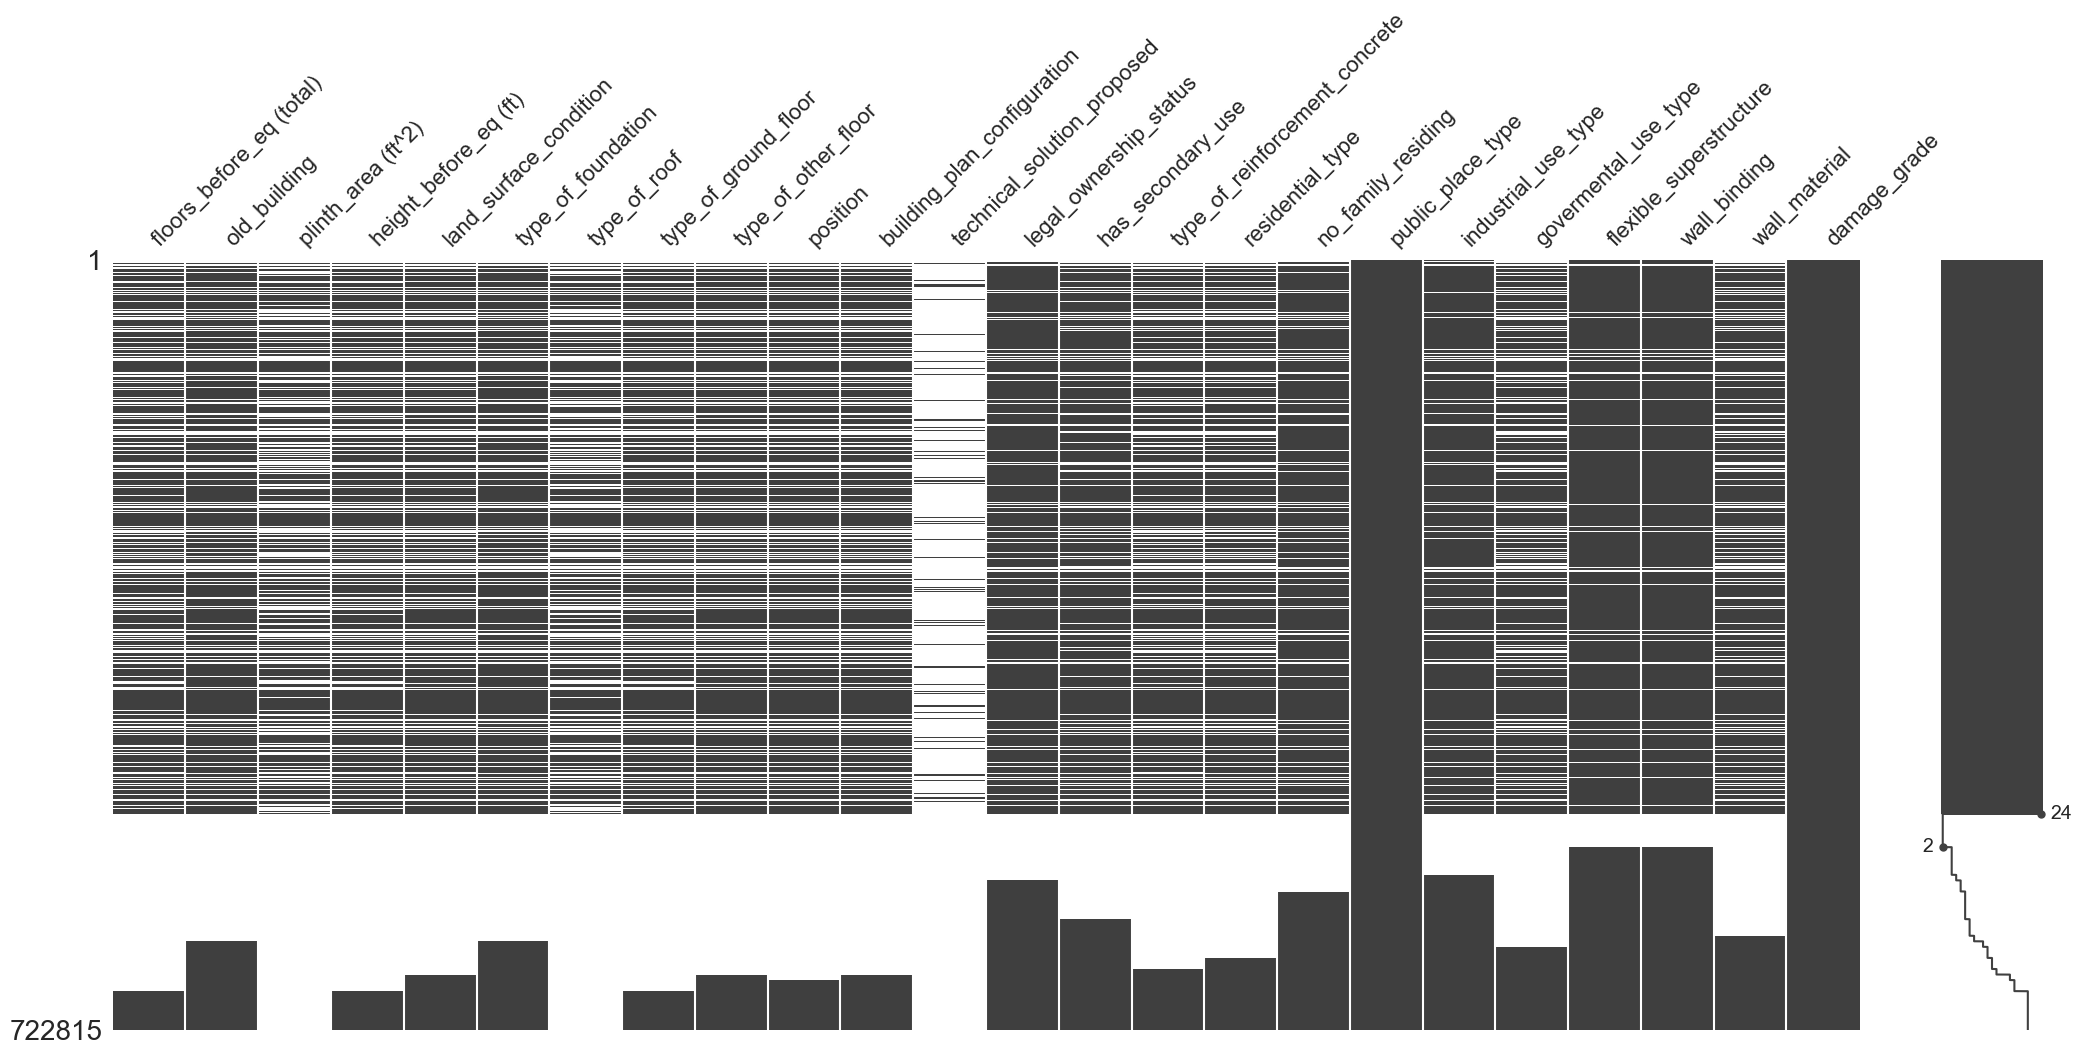

In [12]:
import missingno as msno
msno.matrix(df_clean)


In [13]:
df_test = df_clean.dropna(thresh=22)


In [14]:
df_test.groupby('damage_grade')['technical_solution_proposed'].describe()


,count,unique,top,freq
damage_grade,,,,
1.0,4841,4,No need,3106
2.0,5313,4,Minor repair,4534
3.0,8448,4,Major repair,6293
4.0,11234,3,Reconstruction,10176
5.0,16965,3,Reconstruction,16959


<AxesSubplot:>

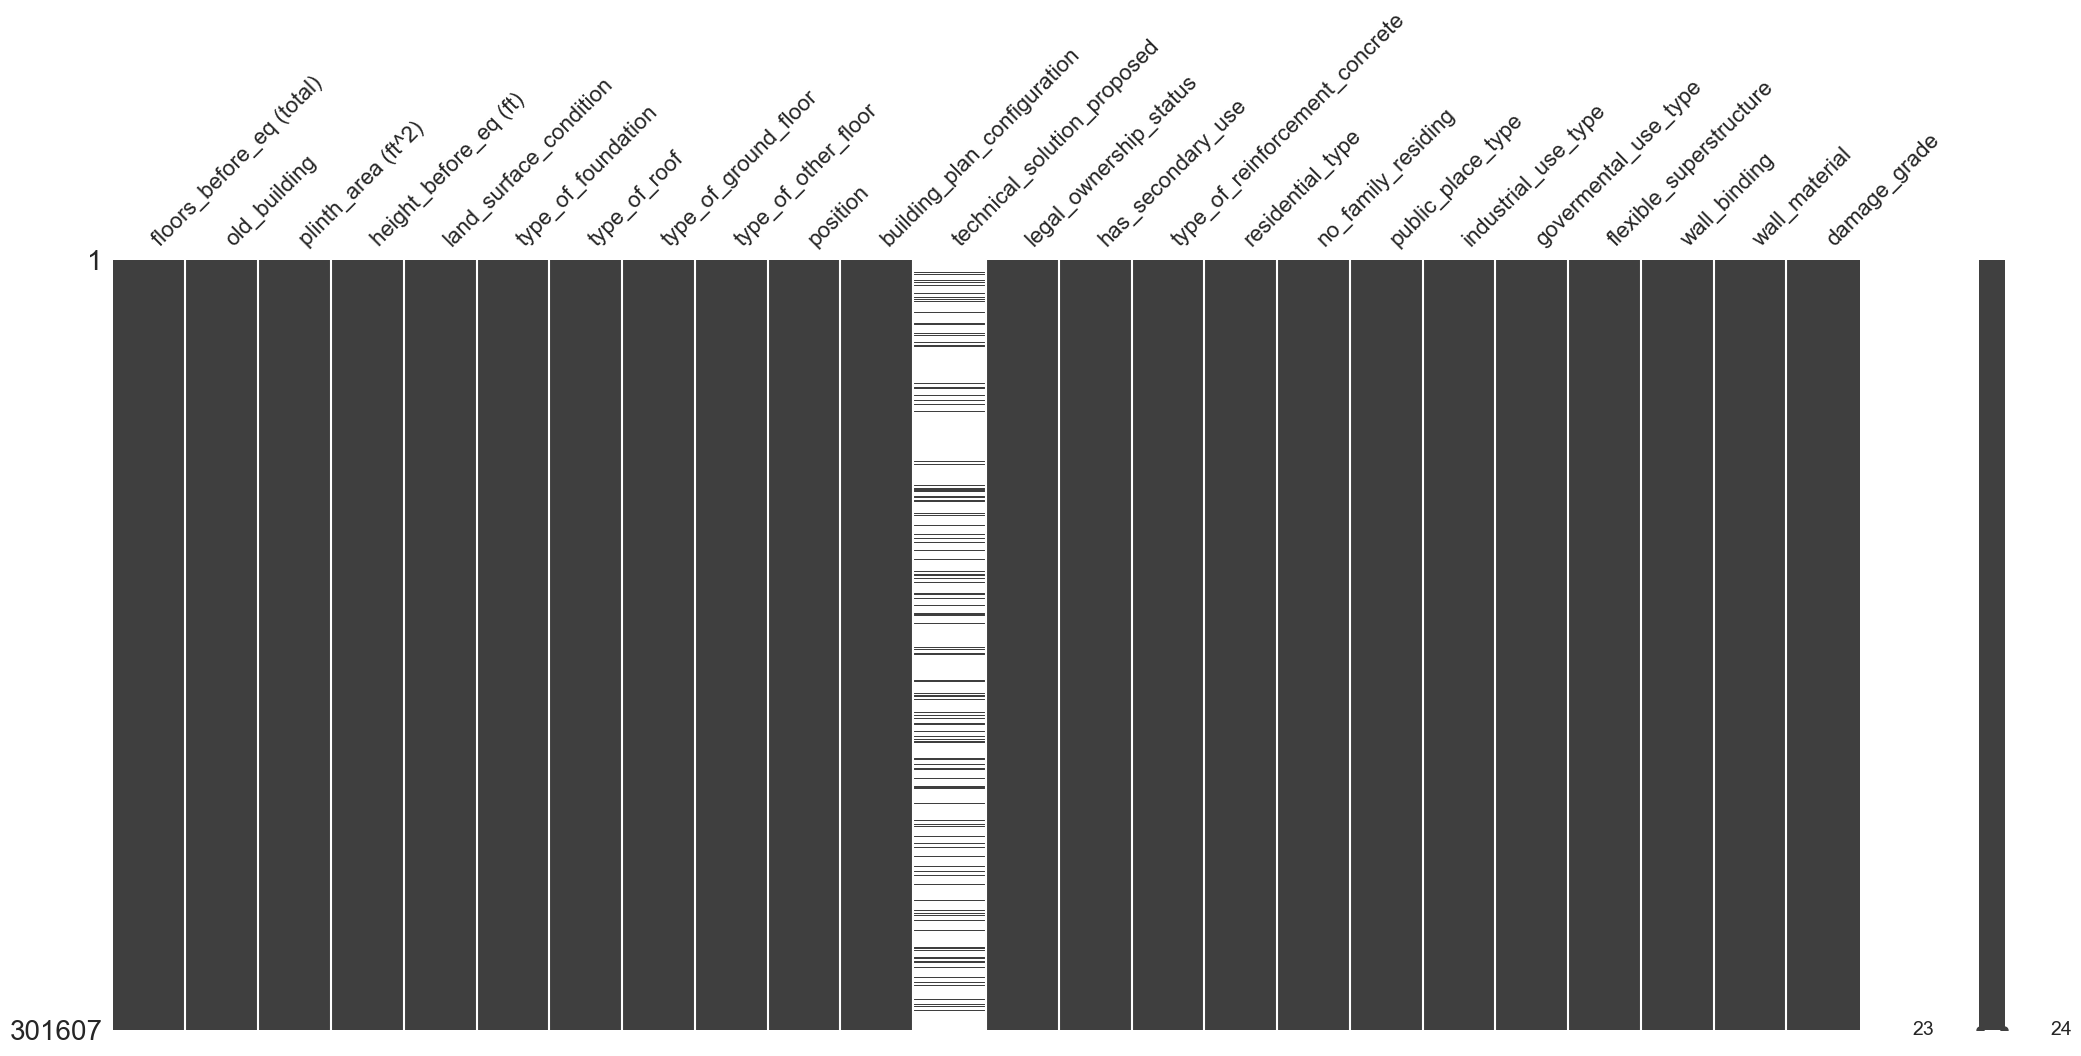

In [15]:
msno.matrix(df_test)


In [16]:
test = np.where(
    df_test['damage_grade'] == 1.0, 'No need',
    np.where(df_test['damage_grade'] == 2.0, 'Minor repair',
             np.where(df_test['damage_grade'] == 3.0, 'Major repair', 'Reconstruction'))
)


In [17]:
df_test['imputed'] = np.where(
    df_test['damage_grade'] == 1.0, 'No need',
    np.where(df_test['damage_grade'] == 2.0, 'Minor repair',
             np.where(df_test['damage_grade'] == 3.0, 'Major repair', 'Reconstruction'))
)


In [18]:
df_test['technical_solution_proposed'].fillna(df_test['imputed'], inplace=True)


In [19]:
df_test.groupby('damage_grade')['technical_solution_proposed'].describe()


,count,unique,top,freq
damage_grade,,,,
1.0,31337,4,No need,29602
2.0,34304,4,Minor repair,33525
3.0,54118,4,Major repair,51963
4.0,72661,3,Reconstruction,71603
5.0,109187,3,Reconstruction,109181


In [20]:
col = df_test.columns


In [21]:
catCol = list(df_test.select_dtypes(include=['object']).columns)


In [22]:
df_test.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 301607 entries, 0 to 520010
Data columns (total 25 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   floors_before_eq (total)        301607 non-null  object 
 1   old_building                    301607 non-null  float64
 2   plinth_area (ft^2)              301607 non-null  object 
 3   height_before_eq (ft)           301607 non-null  float64
 4   land_surface_condition          301607 non-null  object 
 5   type_of_foundation              301607 non-null  object 
 6   type_of_roof                    301607 non-null  object 
 7   type_of_ground_floor            301607 non-null  object 
 8   type_of_other_floor             301607 non-null  object 
 9   position                        301607 non-null  object 
 10  building_plan_configuration     301607 non-null  object 
 11  technical_solution_proposed     301607 non-null  object 
 12  legal_ownership_

In [23]:
import pprint as pp
for i in catCol[2:]:
    print(f"Fitur {i} memiliki fitur berikut")
    pp.pprint(df_test[i].unique())
    print()


Fitur land_surface_condition memiliki fitur berikut
array(['Flat', 'Moderate slope', 'Steep slope'], dtype=object)

Fitur type_of_foundation memiliki fitur berikut
array(['Bamboo or Timber', 'Clay Sand Mixed mortar-Stone/Brick',
       'Clay mortar-Stone/Brick', 'Reinforced Concrete',
       'Cement-Stone or Cement-Brick', 'Mud mortar-Stone/Brick',
       'Bamboo/TImber', 'Bamboo/Timber', 'RC', 'Others',
       'Cement-Stone/Brick', 'Other'], dtype=object)

Fitur type_of_roof memiliki fitur berikut
array(['Bamboo/Timber Light roof', 'Wood Light Roof or Bamboo Heavy Roof',
       'Wood Light Roof or Bamboo Light Roof',
       'Bamboo or Timber Light roof', 'Bamboo/TImber-Light Roof',
       'Reinforced Brick Slab/rcc/rbc', 'Bamboo/Timber Heavy roof',
       'reinforced cement concrete/rb/rbc', 'Bamboo or Timber Heavy roof',
       'Bamboo/TImber-Heavy Roof', 'rcc/rb/rbc',
       'Reinforced brick concrete/rcc/rbc'], dtype=object)

Fitur type_of_ground_floor memiliki fitur berikut
array(

<AxesSubplot:>

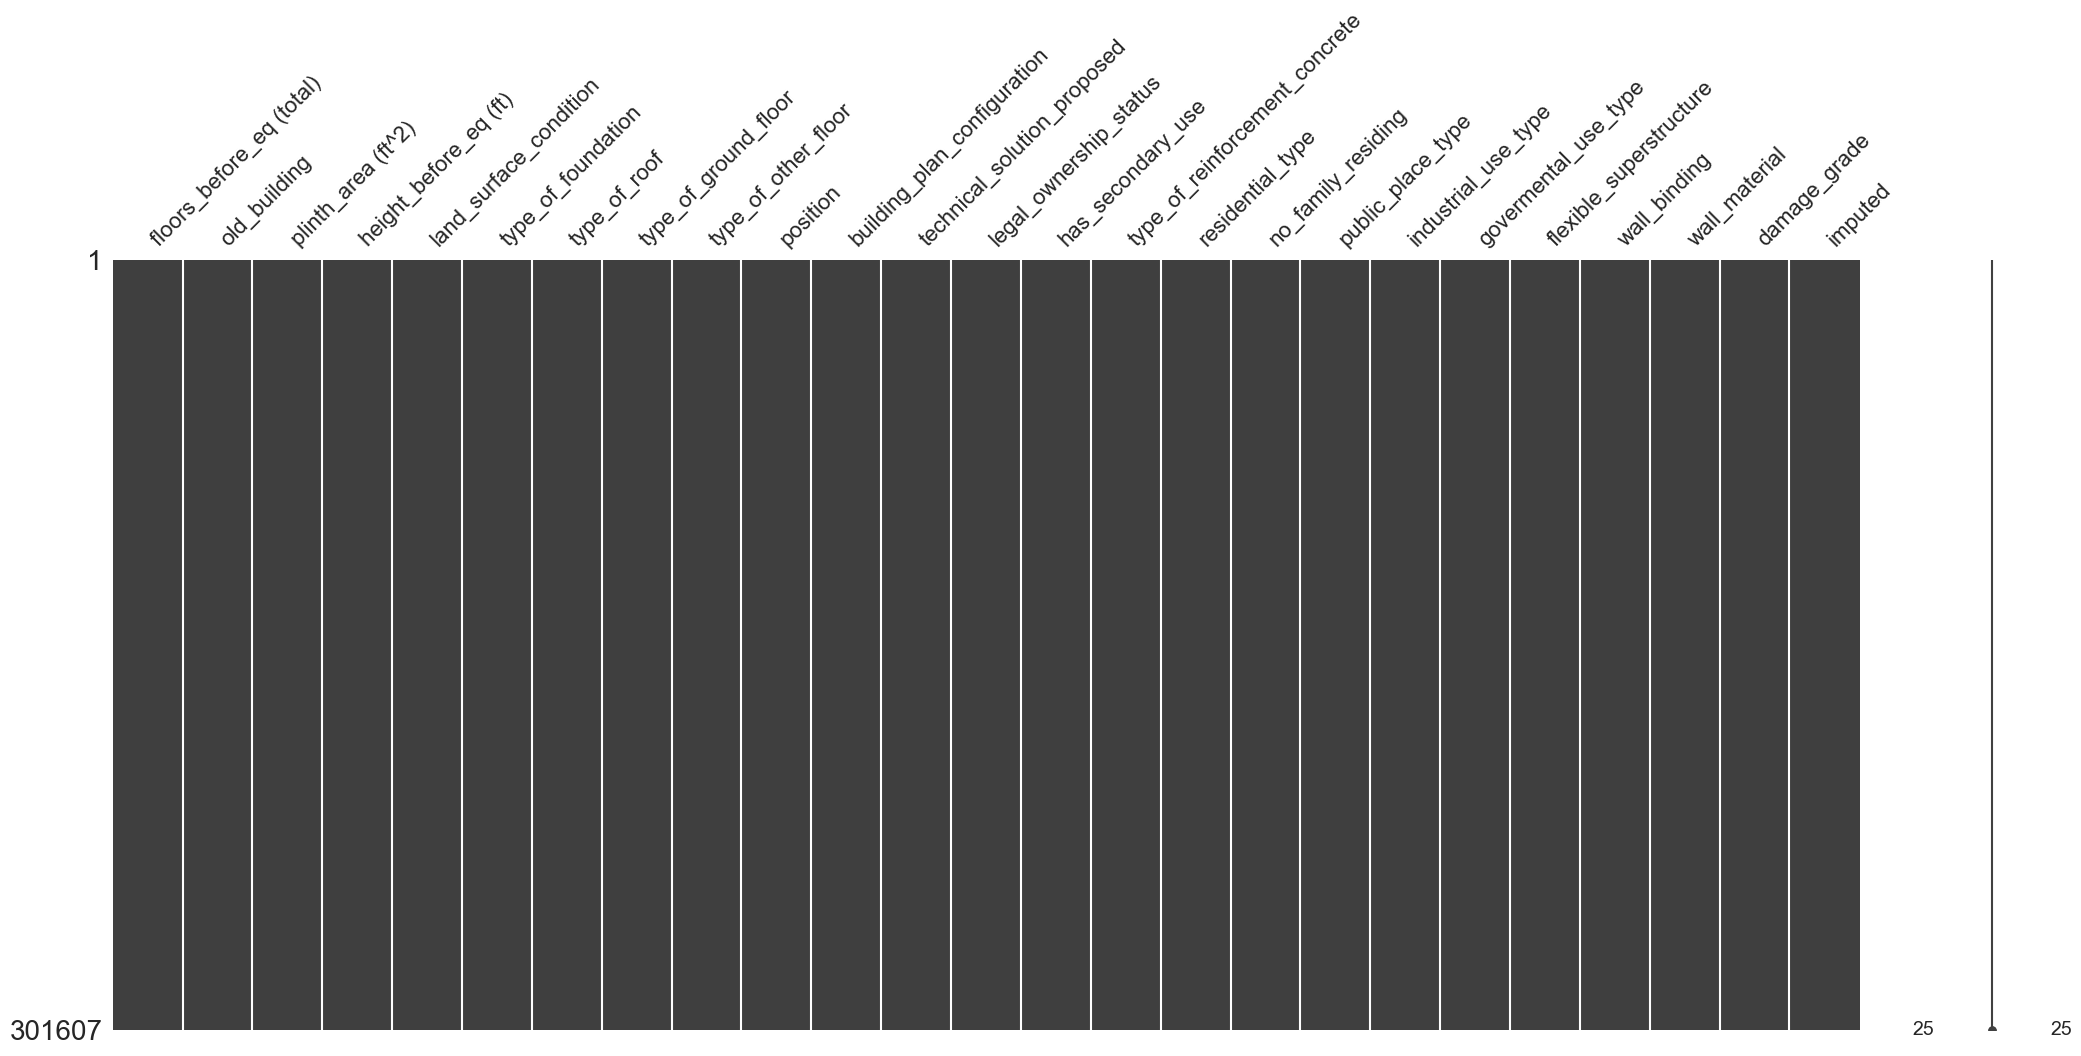

In [24]:
msno.matrix(df_test)


In [25]:
df_test.drop(['imputed'], axis=1, inplace=True)


In [26]:
df_test['floors_before_eq (total)'].unique()


array(['floor two', 'Floor 3', 'two', ' just 2 floor',
       'There is 2 Floor/Story', 'Floor two', '1st Story', 'Floor 2',
       'fifth', '2', 'Has 1 floor', 'one story', 'Three floor',
       'floor second', 'floor third', '3.00', '1', 'floor one',
       'two story', 'Two Floor', ' has 3 Floor', '2 floor', 'three Story',
       'Floor 1', 'floor 1st', 'one', 'Just 1 floor', 'Floor-three',
       'Three', 'four Floor', ' has Four fl', 'Fl four', 'Fl Five', '5',
       '4', 'Floor 4', 'floor four', 'Four Story', 'Four', 'Floor Fifth',
       'five Floor', ' Has Five fl', '6', '8', '9', '7', 'Has Five fl'],
      dtype=object)

In [27]:
df_test.to_csv('technicalImpute.csv')


## Irrelevant Data


In [28]:
df_test.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 301607 entries, 0 to 520010
Data columns (total 24 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   floors_before_eq (total)        301607 non-null  object 
 1   old_building                    301607 non-null  float64
 2   plinth_area (ft^2)              301607 non-null  object 
 3   height_before_eq (ft)           301607 non-null  float64
 4   land_surface_condition          301607 non-null  object 
 5   type_of_foundation              301607 non-null  object 
 6   type_of_roof                    301607 non-null  object 
 7   type_of_ground_floor            301607 non-null  object 
 8   type_of_other_floor             301607 non-null  object 
 9   position                        301607 non-null  object 
 10  building_plan_configuration     301607 non-null  object 
 11  technical_solution_proposed     301607 non-null  object 
 12  legal_ownership_

## floors_before_eq


In [29]:
import re


def clean_fbe(x):
    if type(x) != str:
        return
    word_num = ['one', 'two', 'three', 'four', 'five',
                'six', 'seven', 'eight', 'nine', 'ten', 'eleven', 'twelve']
    th = ['first', 'second', 'third', 'fourth',
          'fifth', 'sixth', 'seventh', 'eight', 'nineth']
    digit = re.search(r'\d', x)
    if digit:
        return int(digit.group(0))

    for i in range(len(word_num)):
        if word_num[i] in x.lower():
            return i+1

    for i in range(len(th)):
        if th[i] in x.lower():
            return i+1
    return 0


In [30]:
df_cl = df_test.copy()


In [31]:
df_cl['floors_before_eq (total)'] = df_cl['floors_before_eq (total)'].apply(
    clean_fbe)


In [32]:
df_cl['floors_before_eq (total)'].unique()


array([2, 3, 1, 5, 4, 6, 8, 9, 7])

## Old Building


In [33]:
# lower_fence, upper_fence = IQR(df_cl, 'old_building')


In [34]:
# df_cl = df_cl[~(lower_fence | upper_fence)]


In [35]:
# sns.boxplot(df_cl['old_building'])


## Area


In [36]:
def clear_plinth_area(x):
    if pd.isna(x):
        return
    else:
        sentences = re.sub('[ ft^2]', '', x)
        try:
            sentences = int(sentences)
        except:
            sentences = 1001
        return sentences*0.3048


In [37]:
df_cl['plinth_area (ft^2)'] = df_cl['plinth_area (ft^2)'].apply(
    clear_plinth_area)


<AxesSubplot:xlabel='plinth_area (ft^2)'>

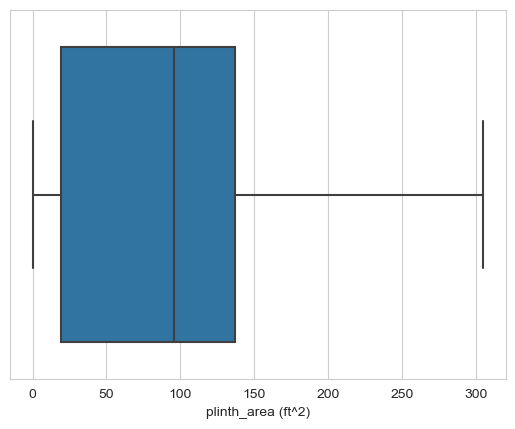

In [38]:
sns.boxplot(df_cl['plinth_area (ft^2)'])


## Height


<AxesSubplot:xlabel='height_before_eq (ft)'>

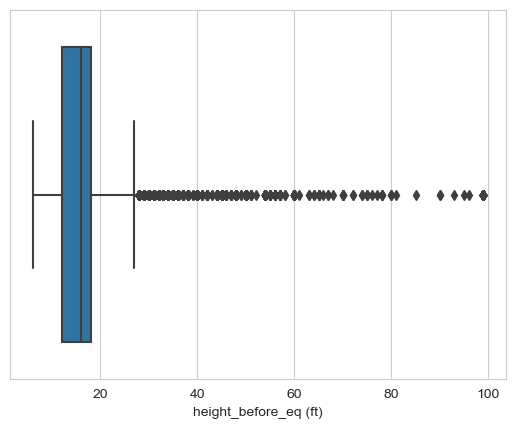

In [39]:
sns.boxplot(df_cl['height_before_eq (ft)'])


## Land Surface Area


In [40]:
df_cl['land_surface_condition'].unique()


array(['Flat', 'Moderate slope', 'Steep slope'], dtype=object)

## Type of foundation


In [41]:
df_cl['type_of_foundation'] = df_cl['type_of_foundation'].str.lower().replace(
    ['rc', 'other'], ['reinforced concrete', 'others'])


## Type of roof


In [42]:
df_cl['type_of_roof'] = df_cl['type_of_roof'].str.lower().replace(
    'rcc/rb/rbc', 'reinforced cement concrete/rb/rbc')


## Type of ground floor


In [43]:
df_cl['type_of_ground_floor'] = df_cl['type_of_ground_floor'].str.lower(
).replace('rc', 'reinforced concrete')


## Type of other floor


In [44]:
df_cl['type_of_other_floor'].str.lower().unique()


array(['timber/bamboo-mud', 'timber mud or bamboo-mud', 'not applicable',
       'wood or bamboo mud', 'rcc/rb/rbc', 'wood-plank', 'timber-planck',
       'lumber-plank', 'wood-mud or bamboo mud',
       'reinforced brick concrete/rcc/rbc',
       'reinforced cement concrete/rb/rbc'], dtype=object)

In [45]:
df_cl['type_of_other_floor'] = df_cl['type_of_other_floor'].str.lower().replace(['timber mud or bamboo-mud',
                                                                                 'timber-planck',
                                                                                 'wood-mud or bamboo mud',
                                                                                 'reinforced cement concrete/rb/rbc',
                                                                                 'reinforced brick concrete/rcc/rbc',
                                                                                 'wood or bamboo mud'],
                                                                                ['timber/bamboo-mud',
                                                                                 'timber-plank',
                                                                                 'wood-mud/bamboo-mud',
                                                                                 'rcc/rb/rbc',
                                                                                 'rcc/rb/rbc',
                                                                                 'wood-mud/bamboo-mud'])


## Position


In [46]:
df_cl['position'].unique()


array(['Not attached', 'Attached-1 side', 'Attached-2 side',
       'Attached-3 side'], dtype=object)

## Building_plan_configuration


1. Simple geometric shapes: 'Rectangular', 'Square', 'L-shape', 'T-shape', 'U-shape', 'H-shape', 'E-shape'
2. Complex shapes: 'Multi-projected', 'Building with Central Courtyard', 'Others'


In [47]:
df_cl['building_plan_configuration'].unique()


array(['Rectangular', 'Square', 'L-shape', 'T-shape', 'Multi-projected',
       'U-shape', 'Others', 'E-shape', 'Building with Central Courtyard',
       'H-shape'], dtype=object)

## Technical Solution Proposed


In [48]:
df_cl['technical_solution_proposed'].unique()


array(['No need', 'Reconstruction', 'Minor repair', 'Major repair'],
      dtype=object)

## legal_ownership_status


In [49]:
df_cl['legal_ownership_status'] = df_cl['legal_ownership_status'].replace(['Private Use', 'Prvt', 'Privste'], 'Private')\
    .replace(['Public Use', 'Public Space'], 'Public')\
    .replace(['Institutional Use', 'Institutionals'], 'Institutional')\
    .replace('Unspecified', 'Unknown')


## has_secondary_use


In [50]:
df_cl['has_secondary_use'].unique()


array([0., 1.])

## Type_of_reinforcement_concrete


In [51]:
df_cl['type_of_reinforcement_concrete'].unique()


array([0., 2., 1., 3.])

In [52]:
tofc = {0: 'No reinforcement concrete',
        1: 'Non-engineered reinforcement concrete',
        2: 'Engineered reinforcement concrete',
        3: 'Both'}


In [53]:
df_cl['type_of_reinforcement_concrete'] = df_cl['type_of_reinforcement_concrete'].map(
    tofc)


## residential_type


In [54]:
df_cl['residential_type'].unique()


array(['Non-residential', 'Hotel/Motel', 'Rental Residential', 'Housing',
       'Other', 'Other Residential Type'], dtype=object)

## no_family_residing


In [55]:
df_cl['no_family_residing'] = df_cl['no_family_residing'].apply(
    lambda x: 0.0 if x == 'None' else float(x))


## public place type


In [149]:
df_cl['public_place_type'].unique()


array(['Non-public', 'Drugstore', 'Shopping Sites', 'Religious Sites',
       'Hospital', 'High School', 'Health Clinics', 'Middle School',
       'Recreational Park', 'Primary School',
       'Other Institutional Building', 'University', 'Museum'],
      dtype=object)

## Industrial use type


In [57]:
df_cl['industrial_use_type'].unique()


array(['Non-industrial', 'Metallurgy', 'Manufacturing', 'Food',
       'Service/Tourism', 'Infrastructure', 'Agro', 'Farm',
       'Forest-based'], dtype=object)

## Goverment use type


In [58]:
df_cl['govermental_use_type'].unique()


array(['Non-govermental', 'Police Offices', 'Govermental Buildings'],
      dtype=object)

## Flexible Superstructure


In [59]:
df_cl['flexible_superstructure'].unique()


array(['unavailable', 'available'], dtype=object)

## wall binding


In [60]:
df_cl['wall_binding'].unique()


array([0., 5., 2., 1., 7., 3.])

In [61]:
wallBinding = {0: 'Unknown/not stated',
               1: 'Clay',
               2: 'Mortar + Cement',
               3: 'Mortar + Cement,Clay',
               5: 'Mud + Mortar,Clay',
               7: 'Mud + Mortar,Clay,Cement + Mortar'}


In [62]:
df_cl['wall_binding'] = df_cl['wall_binding'].map(wallBinding)


## Wall material


In [63]:
wallMaterial = {0: 'Unknown/not stated',
                1: 'Red Bricks',
                2: 'Stone Bricks',
                3: 'Both'}


In [64]:
df_cl['wall_material'] = df_cl['wall_material'].map(wallMaterial)


## Finish


In [65]:
df_cl.head().T


,0,1,3,4,7
floors_before_eq (total),2,3,2,2,2
old_building,1.0,3.0,18.0,22.0,40.0
plinth_area (ft^2),17.0688,300.228,56.388,27.432,153.6192
height_before_eq (ft),22.0,18.0,15.0,17.0,14.0
land_surface_condition,Flat,Flat,Flat,Flat,Flat
type_of_foundation,bamboo or timber,clay sand mixed mortar-stone/brick,clay sand mixed mortar-stone/brick,clay sand mixed mortar-stone/brick,clay mortar-stone/brick
type_of_roof,bamboo/timber light roof,wood light roof or bamboo heavy roof,wood light roof or bamboo light roof,bamboo or timber light roof,bamboo/timber light roof
type_of_ground_floor,clay,clay,clay,clay,clay
type_of_other_floor,timber/bamboo-mud,timber/bamboo-mud,timber/bamboo-mud,timber/bamboo-mud,timber/bamboo-mud
position,Not attached,Not attached,Not attached,Not attached,Not attached


# Feature Engineering


# Modeling SVM (svc)


In [66]:
objectCol = list(df_cl.select_dtypes(include=['object']).columns)
numCol = list(df_cl.select_dtypes(exclude=['object']).columns)[:-1]


In [67]:
features = df_cl.iloc[:, :-1]
target = df_cl.iloc[:, -1]


In [68]:
from sklearn.model_selection import train_test_split, GridSearchCV

# split data into 80% training and 20% test sets
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42)


In [69]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
numeric_features = numCol
categorical_features = objectCol
numeric_transformer = make_pipeline(StandardScaler())
categorical_transformer = make_pipeline(OneHotEncoder())
Preprocessor = ColumnTransformer(
    transformers=[
        ('numeric_transformer', numeric_transformer, numeric_features),
        ('categorical_transformer', categorical_transformer, categorical_features)
    ])


In [ ]:
# explicitly require this experimental feature
from sklearn.experimental import enable_hist_gradient_boosting
# now you can import normally from ensemble
from sklearn.ensemble import HistGradientBoostingClassifier


In [71]:
from sklearn.svm import SVC


In [72]:
# hgb_pipe = make_pipeline(Preprocessor, HistGradientBoostingClassifier())


NameError: name 'HistGradientBoostingClassifier' is not defined

In [74]:
if 1 == 0:
    svc_pipe = make_pipeline(Preprocessor, SVC(kernel='rbf', verbose=True))


In [75]:
if 1 == 0:
    svc_pipe.fit(X_train, y_train)


[LibSVM]...................
*.........................................*.*
optimization finished, #iter = 60928
obj = -3020.088624, rho = 0.061486
nSV = 6718, nBSV = 1835
...*...*
optimization finished, #iter = 6339
obj = -1150.891823, rho = -0.141843
nSV = 2217, nBSV = 992
..*..*
optimization finished, #iter = 4956
obj = -277.131109, rho = -0.176767
nSV = 1398, nBSV = 131
..*..*
optimization finished, #iter = 4325
obj = -189.840732, rho = -0.075088
nSV = 1292, nBSV = 74
...................
*...........................*.*
optimization finished, #iter = 46928
obj = -2401.479997, rho = 0.028592
nSV = 5935, nBSV = 1465
.....
*....*
optimization finished, #iter = 9752
obj = -1378.288021, rho = -0.017917
nSV = 2640, nBSV = 1139
....
*......*
optimization finished, #iter = 10757
obj = -419.914196, rho = 0.096526
nSV = 2129, nBSV = 197
....................................
*............................................................................*.*
optimization finished, #iter = 113234
obj 

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric_transformer',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['floors_before_eq (total)',
                                                   'old_building',
                                                   'plinth_area (ft^2)',
                                                   'height_before_eq (ft)',
                                                   'has_secondary_use',
                                                   'no_family_residing']),
                                                 ('categorical_transformer',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder())...
                          

In [76]:
import joblib


In [77]:
# joblib.dump(svc_pipe,'model.pkl')


['model.pkl']

In [79]:
y_pred = svc_pipe.predict(X_test)


In [80]:
from sklearn.metrics import f1_score
f1_score(y_pred, y_test, average='macro')


0.7829086819567854

# Data Test


In [81]:
df_ed = pd.read_csv('./Dataset/test.csv')


In [166]:
df_ed.head()


,id,floors_before_eq (total),old_building,plinth_area (ft^2),height_before_eq (ft),land_surface_condition,type_of_foundation,type_of_roof,type_of_ground_floor,type_of_other_floor,...,has_secondary_use,type_of_reinforcement_concrete,residential_type,no_family_residing,public_place_type,industrial_use_type,govermental_use_type,flexible_superstructure,wall_binding,wall_material
0,0,2,7,127.4064,14,Flat,clay mortar-stone/brick,bamboo/timber-light roof,clay,TImber/Bamboo-Mud,...,0.0,No reinforcement concrete,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,"Mud + Mortar,Clay",Stone Bricks
1,1,3,13,120.7008,21,Flat,clay mortar-stone/brick,bamboo/timber-heavy roof,brick or stone,TImber/Bamboo-Mud,...,0.0,No reinforcement concrete,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,"Mud + Mortar,Clay",Stone Bricks
2,2,3,40,121.9200,18,Flat,clay mortar-stone/brick,bamboo/timber light roof,clay,Wood or Bamboo Mud,...,0.0,No reinforcement concrete,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,"Mud + Mortar,Clay",Stone Bricks
3,3,2,25,115.2144,20,Flat,bamboo or timber,bamboo/timber heavy roof,mud,TImber/Bamboo-Mud,...,0.0,No reinforcement concrete,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,"Mud + Mortar,Clay",Stone Bricks
4,4,2,5,114.3000,20,Flat,mud mortar-stone/brick,wood light roof or bamboo light roof,clay,Wood-Mud or Bamboo Mud,...,0.0,No reinforcement concrete,Non-residential,1.0,Non-public,Non-industrial,Non-govermental,unavailable,"Mud + Mortar,Clay",Stone Bricks


In [86]:
df_ed['floors_before_eq (total)'] = df_ed['floors_before_eq (total)'].apply(
    clean_fbe)


In [92]:
df_ed['plinth_area (ft^2)'] = df_ed['plinth_area (ft^2)'].apply(
    clear_plinth_area)


In [98]:
df_cl['type_of_foundation'].str.lower().replace(
    ['rc', 'other'], ['reinforced concrete', 'others']).unique()

array(['bamboo or timber', 'clay sand mixed mortar-stone/brick',
       'clay mortar-stone/brick', 'reinforced concrete',
       'cement-stone or cement-brick', 'mud mortar-stone/brick',
       'bamboo/timber', 'others', 'cement-stone/brick'], dtype=object)

In [102]:
df_ed['type_of_foundation'] = df_ed['type_of_foundation'].str.lower().replace(
    ['rc', 'other'], ['reinforced concrete', 'others'])


In [167]:
df_ed['type_of_other_floor'] = df_ed['type_of_other_floor'].str.lower().replace(['timber mud or bamboo-mud',
                                                                                'timber-planck',
                                                                                'wood-mud or bamboo mud',
                                                                                'reinforced cement concrete/rb/rbc',
                                                                                'reinforced brick concrete/rcc/rbc',
                                                                                'wood or bamboo mud'],
                                                                                ['timber/bamboo-mud',
                                                                                'timber-plank',
                                                                                'wood-mud/bamboo-mud',
                                                                                'rcc/rb/rbc',
                                                                                'rcc/rb/rbc',
                                                                                'wood-mud/bamboo-mud'])


In [107]:
df_ed['type_of_ground_floor'] = df_ed['type_of_ground_floor'].str.lower().replace(
    'rc', 'reinforced concrete')


In [122]:
df_cl['type_of_roof'].unique()


array(['bamboo/timber light roof', 'wood light roof or bamboo heavy roof',
       'wood light roof or bamboo light roof',
       'bamboo or timber light roof', 'bamboo/timber-light roof',
       'reinforced brick slab/rcc/rbc', 'bamboo/timber heavy roof',
       'reinforced cement concrete/rb/rbc', 'bamboo or timber heavy roof',
       'bamboo/timber-heavy roof', 'reinforced brick concrete/rcc/rbc'],
      dtype=object)

In [125]:
df_ed['type_of_roof'] = df_ed['type_of_roof'].str.lower().replace(
    ['rcc/rb/rbc'], ['reinforced cement concrete/rb/rbc'])


In [126]:
df_ed['type_of_other_floor'].str.lower().unique()


array(['timber/bamboo-mud', 'wood or bamboo mud',
       'wood-mud or bamboo mud', 'timber mud or bamboo-mud',
       'timber-planck', 'lumber-plank', 'not applicable', 'rcc/rb/rbc',
       'reinforced brick concrete/rcc/rbc', 'wood-plank',
       'reinforced cement concrete/rb/rbc'], dtype=object)

In [128]:
df_ed['legal_ownership_status'] = df_ed['legal_ownership_status'].replace(['Private Use', 'Prvt', 'Privste'], 'Private')\
    .replace(['Public Use', 'Public Space'], 'Public')\
    .replace(['Institutional Use', 'Institutionals'], 'Institutional')\
    .replace('Unspecified', 'Unknown')


In [133]:
df_ed['type_of_reinforcement_concrete'] = df_ed['type_of_reinforcement_concrete'].map(tofc)

In [139]:
df_ed['no_family_residing'] = df_ed['no_family_residing'].apply(
    lambda x: 0.0 if x == 'None' else float(x))


In [150]:
df_ed['public_place_type'].unique()

array(['Non-public', 'High School', 'Middle School',
       'Other Institutional Building', 'Hospital', 'Shopping Sites',
       'Drugstore', 'Religious Sites', 'Primary School', 'Health Clinics',
       'Museum', 'University', 'Recreational Park'], dtype=object)

In [151]:
df_ed['industrial_use_type'].unique()


array(['Non-industrial', 'Food', 'Infrastructure', 'Service/Tourism',
       'Manufacturing', 'Metallurgy', 'Forest-based', 'Farm', 'Agro'],
      dtype=object)

In [152]:
df_ed['govermental_use_type'].unique()


array(['Non-govermental', 'Police Offices', 'Govermental Buildings'],
      dtype=object)

In [157]:
df_ed['wall_material'].unique()

array(['Stone Bricks', 'Unknown/not stated', 'Red Bricks', 'Both'],
      dtype=object)

In [154]:
df_ed['wall_binding'] = df_ed['wall_binding'].map(wallBinding)


In [156]:
df_ed['wall_material'] = df_ed['wall_material'].map(wallMaterial)


In [158]:
df_ed.head().T

,0,1,2,3,4
id,0,1,2,3,4
floors_before_eq (total),2,3,3,2,2
old_building,7,13,40,25,5
plinth_area (ft^2),127.4064,120.7008,121.92,115.2144,114.3
height_before_eq (ft),14,21,18,20,20
land_surface_condition,Flat,Flat,Flat,Flat,Flat
type_of_foundation,clay mortar-stone/brick,clay mortar-stone/brick,clay mortar-stone/brick,bamboo or timber,mud mortar-stone/brick
type_of_roof,bamboo/timber-light roof,bamboo/timber-heavy roof,bamboo/timber light roof,bamboo/timber heavy roof,wood light roof or bamboo light roof
type_of_ground_floor,clay,brick or stone,clay,mud,clay
type_of_other_floor,TImber/Bamboo-Mud,TImber/Bamboo-Mud,Wood or Bamboo Mud,TImber/Bamboo-Mud,Wood-Mud or Bamboo Mud


In [168]:
y_pred = svc_pipe.predict(df_ed)

In [169]:
res = pd.read_csv('./Dataset/sample_submission.csv')

In [170]:
res.head()

,id,damage_grade
0,0,5
1,1,1
2,2,4
3,3,4
4,4,4


In [177]:
res['damage_grade'] = y_pred

In [181]:
res['damage_grade'] = res['damage_grade'].astype('int')

In [182]:
res.to_csv('svm_submission.csv', index=False)

In [134]:
df_ed.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242082 entries, 0 to 242081
Data columns (total 24 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              242082 non-null  int64  
 1   floors_before_eq (total)        242082 non-null  int64  
 2   old_building                    242082 non-null  int64  
 3   plinth_area (ft^2)              242082 non-null  float64
 4   height_before_eq (ft)           242082 non-null  int64  
 5   land_surface_condition          242082 non-null  object 
 6   type_of_foundation              242082 non-null  object 
 7   type_of_roof                    242082 non-null  object 
 8   type_of_ground_floor            242082 non-null  object 
 9   type_of_other_floor             242082 non-null  object 
 10  position                        242082 non-null  object 
 11  building_plan_configuration     242082 non-null  object 
 12  technical_soluti

In [184]:
df_cl['damage_grade'].value_counts()

5.0    109187
4.0     72661
3.0     54118
2.0     34304
1.0     31337
Name: damage_grade, dtype: int64

# Undersampling

In [213]:
df_s = df_cl.copy()

In [214]:
features, target = df_s.iloc[:,:-1], df_s.iloc[:,-1]

In [ ]:
df_s[objectCol] = StandardScaler.fit_tr

In [218]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
Counter(target)

Counter({1.0: 31337, 5.0: 109187, 4.0: 72661, 2.0: 34304, 3.0: 54118})

In [219]:
# resampling X, y
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_resample(features, target)
# new class distribution
print(Counter(y_rus))


Counter({1.0: 31337, 2.0: 31337, 3.0: 31337, 4.0: 31337, 5.0: 31337})


In [231]:
if 1 == 1:
    svc_new = make_pipeline(Preprocessor, SVC(kernel='rbf', verbose=True, random_state=42, cache_size=2000))


In [240]:
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42)


In [241]:
X_rus, y_rus = rus.fit_resample(X_train, y_train)

In [243]:
if 1 == 1:
    svc_new.fit(X_rus, y_rus)


[LibSVM].....................
*......................................*.*
optimization finished, #iter = 59862
obj = -2999.867603, rho = 0.040202
nSV = 6423, nBSV = 1843
....*..*
optimization finished, #iter = 6708
obj = -775.713052, rho = -0.302075
nSV = 1875, nBSV = 565
..*..*
optimization finished, #iter = 4094
obj = -225.954510, rho = -0.343383
nSV = 1141, nBSV = 117
.*..*
optimization finished, #iter = 3195
obj = -149.534068, rho = -0.304860
nSV = 967, nBSV = 68
..............
*...................*
optimization finished, #iter = 33676
obj = -1828.396432, rho = -0.129747
nSV = 4519, nBSV = 1113
...*..*
optimization finished, #iter = 5471
obj = -1024.118529, rho = -0.202454
nSV = 1877, nBSV = 921
...
*....*
optimization finished, #iter = 7129
obj = -354.956233, rho = -0.129814
nSV = 1473, nBSV = 170
..................
*..................................*
optimization finished, #iter = 52537
obj = -2385.574784, rho = -0.145418
nSV = 5371, nBSV = 1478
..........
*......................

In [244]:
joblib.dump(svc_new,'modelSVM2.pkl')

['modelSVM2.pkl']

In [245]:
y_pred_svm = svc_new.predict(X_test)

In [246]:
from sklearn.metrics import f1_score
f1_score(y_pred_svm, y_test, average='macro')

0.8084238265582231

In [247]:
Counter(y_pred_svm)

Counter({5.0: 20464, 4.0: 15998, 3.0: 10828, 2.0: 7068, 1.0: 5964})

In [248]:
svc_new[1].get_params(deep=True)

{'C': 1.0,
 'break_ties': False,
 'cache_size': 2000,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': True}

In [252]:
y_pred_sub = svc_new.predict(df_ed)

In [250]:
resSVM = pd.read_csv('./Dataset/sample_submission.csv')


In [253]:
resSVM['damage_grade'] = y_pred_sub

In [254]:
resSVM['damage_grade'] = resSVM['damage_grade'].astype('int')

In [255]:
resSVM['damage_grade'].value_counts()

5    82847
4    66482
3    41203
2    35100
1    16450
Name: damage_grade, dtype: int64

In [261]:
resSVM

,id,damage_grade
0,0,4
1,1,5
2,2,5
3,3,4
4,4,2
...,...,...
242077,242077,3
242078,242078,5
242079,242079,1
242080,242080,4


In [262]:
resSVM.to_csv('svm_submission2.csv', index=False)

In [256]:
t = pd.read_csv('./Dataset/sample_submission.csv')

In [257]:
t['damage_grade'].value_counts()

4    48773
5    48595
2    48313
1    48277
3    48124
Name: damage_grade, dtype: int64